# FACIES VISUALIZATION AND CLASSIFICATION USING DEEP LEARNING

#### BY TANMAY GUPTA AND ADITYA KOTHARI
Facies classification, assigning a rock type or a class to specific rock examples on the basis of measured rock properties is a fundamental step in geological interpretations and a variety of useful classification schemes may be employed.

This notebook demonstrates how to train a machine learning algorithm(an Artificial Neural Network) to predict facies from well log data.  The dataset we will use comes from a class excercise from The University of Kansas on [Neural Networks and Fuzzy Systems](http://www.people.ku.edu/~gbohling/EECS833/).  This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see [Bohling and Dubois (2003)](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf) and [Dubois et al. (2007)](http://dx.doi.org/10.1016/j.cageo.2006.08.011). 

The dataset we will use is log data from nine wells that have been labeled with a facies type based on oberservation of core.  We will use this log data to train a artificial neural network to classify facies types.  Artificial neural networks or connectionist systems are computing systems vaguely inspired by the biological neural networks that constitute animal brains. Such systems "learn" to perform tasks by considering examples, generally without being programmed with task-specific rules.
With the help of Tensorflow and Keras libraries we will be able to build our model.

First we will explore the dataset.  We will load the training data from 9 wells, and take a look at what we have to work with.  We will plot the data from a couple wells, and create cross plots to look at the variation within the data.  

Next we will condition the data set.  The data will be scaled to have zero mean and unit variance.  We will also split the data into training and test sets and thus preprocessing of data is performed.

We will then be ready to build or neural network.  We will demonstrate how to use the Tensorflow to bulid different layers and then plot the confusion matrix and other graphs to get the accuracy of the model and visualise the learning.

Finally, once we have a built and tuned the classifier, we can apply the trained model to classify facies in wells which do not already have labels.  We will apply the classifier to two wells, but in principle you could apply the classifier to any number of wells that had the same log data.

## Uploading the dataset

Since this notebook is developed on Google Colab therefore we need to upload the required dataset to the server.

In [1]:
from google.colab import files
uploaded = files.upload()

Saving ann.png to ann.png
Saving model.png to model.png
Saving new_data_nofacies.csv to new_data_nofacies.csv
Saving training_data.csv to training_data.csv


## Exploring the dataset

First, we will examine the data set we will use to train the classifier.  The training data is contained in the file `training_data.csv`.  The dataset consists of 5 wireline log measurements, two indicator variables and a facies label at half foot intervals.  In machine learning terminology, each log measurement is a feature vector that maps a set of 'features' (the log measurements) to a class (the facies type).  We will use the pandas library to load the data into a dataframe, which provides a convenient data structure to work with well log data.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

filename = 'training_data.csv'
training_data = pd.read_csv(filename)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
3227,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
3228,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
3229,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
3230,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


This data is from the Council Grove gas reservoir in Southwest Kansas.  The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas.  This dataset is from nine wells (with 4062 examples). It is divided into two parts 
1. Training data (3232 examples) - 
It consist of a set of seven predictor variables and a rock facies (class) for each example vector.
2. Test/New data (830 examples from two wells) - 
They have the same seven predictor variables in the feature vector but not the facies(class) to which they belong to.

Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate. 

The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8

Let's clean up this dataset.  The 'Well Name' and 'Formation' columns can be turned into a categorical data type.  

In [3]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

[SHRIMPLIN, SHANKLE, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (8, object): [SHRIMPLIN, SHANKLE, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY,
                         CHURCHMAN BIBLE]

In [4]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


This is a quick view of the statistical distribution of the input variables.  Looking at the `count` values, there are 3232 feature vectors in the training set.

These are the names of the 10 training wells in the Council Grove reservoir.  Data has been recruited into pseudo-well 'Recruit F9' to better represent facies 9, the Phylloid-algal bafflestone. 

Before we plot the well data, let's define a color map so the facies are represented by consistent color in all the plots in this notebook.  We also create the abbreviated facies labels, and add those to the `training_data` dataframe.

In [5]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,FSiS
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,FSiS
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,FSiS
...,...,...,...,...,...,...,...,...,...,...,...,...
3227,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685,MS
3228,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677,MS
3229,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669,MS
3230,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661,MS


Let's take a look at the data from individual wells in a more familiar log plot form.  We will create plots for the five well log variables, as well as a log for facies labels.

In [6]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
#     print(logs)
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
#    print(ztop,",",zbot)
    
#   print(logs['Facies'].values.shape)
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), repeats=100, axis=1)
    print(cluster.shape)
#     print(cluster)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g') # -g is for green
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])

Placing the log plotting code in a function will make it easy to plot the logs from multiples wells, and can be reused later to view the results when we apply the facies classification model to other wells.  The function was written to take a list of colors and facies labels as parameters.  

We then show log plots for wells `SHRIMPLIN`.  

(471, 100)


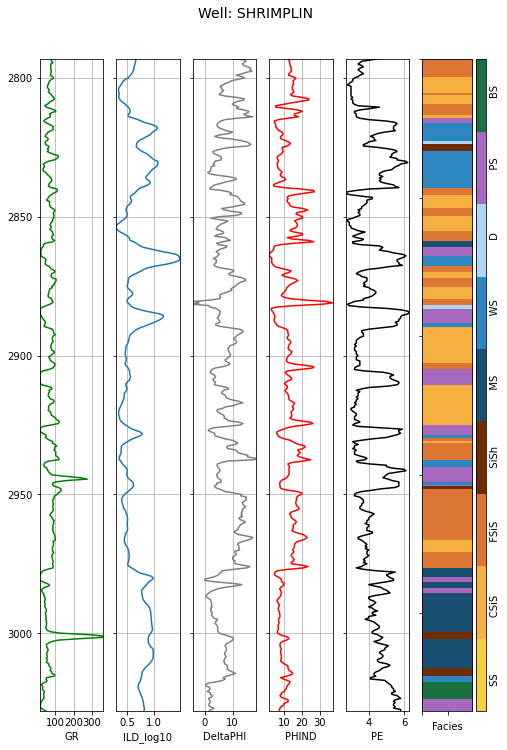

In [7]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

In addition to individual wells, we can look at how the various facies are represented by the entire training set.  Let's plot a histogram of the number of training examples for each facies class.

SS      259
CSiS    738
FSiS    615
SiSh    184
MS      217
WS      462
D        98
PS      498
BS      161
Name: Facies, dtype: int64

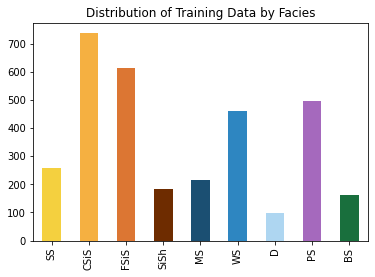

In [8]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index() # sort from 1 to 9
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts

This shows the distribution of examples by facies for the examples in the training set.  Dolomite (facies 7) has the fewest with 81 examples.  Depending on the performance of the classifier we are going to train, we may consider getting more examples of these facies.

Crossplots are a familiar tool in the geosciences to visualize how two properties vary with rock type.  This dataset contains 5 log variables, and scatter matrix can help to quickly visualize the variation between the all the variables in the dataset.  We can employ the very useful [Seaborn library](https://stanford.edu/~mwaskom/software/seaborn/) to quickly create a nice looking scatter matrix. Each pane in the plot shows the relationship between two of the variables on the x and y axis, with each point is colored according to its facies.  The same colormap is used to represent the 9 facies.  

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/

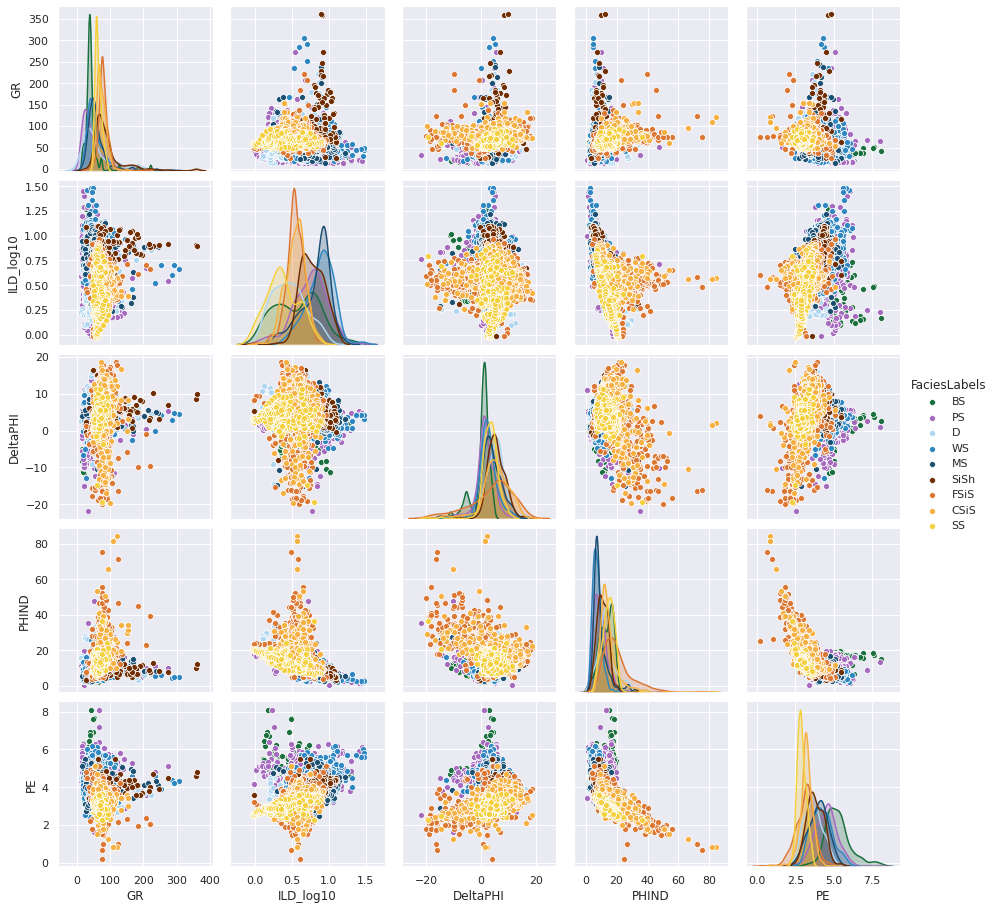

In [9]:
#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)

# **Building the Neural Network**

Now since the visualization part is done we move on to bulid our neural network classifier.

The steps taken in this part will be as follows - 
1.  Importing and processing the dataset
2.  Spitting the data into train and test
3.  Normalising the input features to have zero mean and unit variance so that the learning could be fast and easy
4.  Building and training the model
5.  Finding the accuray and visualizing the results

## Importing and processing the dataset

In [10]:
# Importing the dataset
dataset = pd.read_csv('training_data.csv')

dataset.head()


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [11]:
# get the ground truth in Y
y = dataset.iloc[:,:1].values # thr 0th column is the ground truth value

j=np.unique(y) # no. of classes
print("Classes-", j)

from tensorflow.keras.utils import to_categorical
Y = to_categorical(y, 10) # converts 1-9 into categorical data with 10 columns indexed 0-9
y = np.delete(Y, 0, axis=1) # deleting the column at 0 index

print(Y[0,:])
print(y[0,:])


Classes- [1 2 3 4 5 6 7 8 9]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [12]:
# get the features in X
X = dataset.iloc[:,2:] # dropped the Formation column
print("Original dataset without ground truth: ")
X.head()

Original dataset without ground truth: 


,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


## Spltting the dataset

We will split the data into training(80%) and testing(20%) and random state equal to 0.

In [13]:
# splitting the data
from sklearn.model_selection import train_test_split
X_train_data, X_test_data, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print("Training Data: ")
X_train_data.head() # train still in readable format

Training Data: 


,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
396,SHRIMPLIN,2991.0,46.690,0.918000,2.1,6.705,4.20,2,0.725
76,SHRIMPLIN,2831.0,32.760,1.071000,3.0,6.225,5.80,2,0.333
2560,NEWBY,2923.5,83.410,0.579000,2.3,14.450,3.20,2,0.026
1512,CROSS H CATTLE,2640.0,70.887,0.757851,7.2,15.900,3.59,1,0.727
1222,LUKE G U,2761.5,77.060,0.455000,-2.4,22.900,3.00,1,0.333


In [14]:
print("Testing/Validation Data: ")
X_test_data.head() # test data in readable format

Testing/Validation Data: 


,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
1462,CROSS H CATTLE,2614.0,95.024,0.891983,8.700,8.850,4.131,2,0.773
3103,CHURCHMAN BIBLE,3058.5,113.875,0.404000,5.099,16.239,3.463,2,0.850
599,SHANKLE,2839.0,53.380,0.819000,-0.100,7.125,3.300,1,0.490
2609,NEWBY,2948.0,64.930,0.588000,3.300,10.650,3.300,1,0.429
2670,NEWBY,2978.5,90.910,0.342000,12.900,20.050,3.300,1,0.385


## Preprocessing the data

We will feature scale and normalize the data with the help of Standered Scaler normalizer present in the sklearn library.

In [15]:

X_train = X_train_data.iloc[:,1:].values # extracting the values from the data for the mode
X_test = X_test_data.iloc[:,1:].values

# Feature Scaling to normalise the data of each feature vector
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print("X_train and X_test shape")
print(X_train.shape,X_test.shape)
print("Y_train and Y_test shape")
print(y_train.shape,y_test.shape)


X_train and X_test shape
(2585, 8) (647, 8)
Y_train and Y_test shape
(2585, 9) (647, 9)


## Build a model using Tensorflow

We are now ready to bulid our model using Tensorflow and Keras. We will import the library and create our model consisting of five layers.

1. Dense Layer of 128 neurons with activation function of relu
2. Dense Layer of 68 neurons with activation function of relu
3. Dense Layer of 68 neurons with activation function of relu
4. Dense Layer of 48 neurons with activation function of relu
5. Dense Layer of 9 neurons with activation function of softmax

Then we will compile the model with Adam's Optimizer.

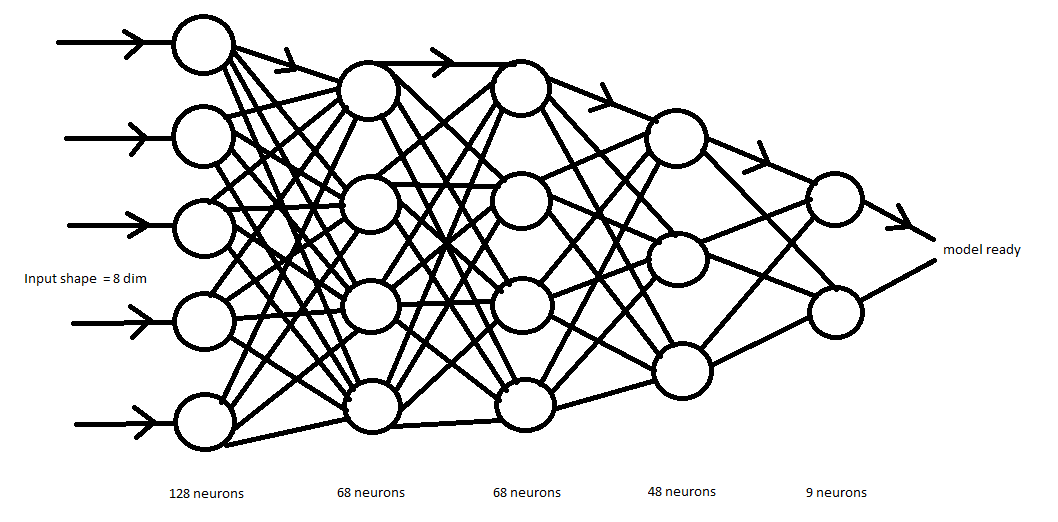

In [16]:
from IPython.display import Image
Image(filename='ann.png')

In [19]:
# Tensorflow
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(128,input_shape=[8], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(68, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(68, activation=tf.nn.relu), # , kernel_regularizer=l2(0.001)
                                    tf.keras.layers.Dense(48, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(9, activation=tf.nn.softmax)
                                    ])

model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

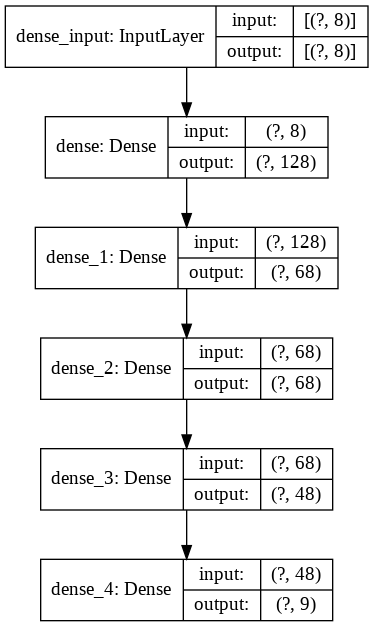

In [20]:
from IPython.display import SVG, Image

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png',width=300, height=150)

## Train the model

We will then train the model with a batch size of 22 ,verbose of 1 and number of epochs equal to 80.

In [22]:
# train the model with 80 epochs
hist=model.fit(X_train, y_train, batch_size=22, epochs=80, verbose=1, validation_data=(X_test, y_test))

Epoch 1/80
118/118 [==============================] - 1s 6ms/step - loss: 1.4126 - accuracy: 0.4387 - val_loss: 1.0885 - val_accuracy: 0.5518
Epoch 2/80
118/118 [==============================] - 1s 4ms/step - loss: 1.0230 - accuracy: 0.5872 - val_loss: 1.0395 - val_accuracy: 0.5657
Epoch 3/80
118/118 [==============================] - 0s 4ms/step - loss: 0.9427 - accuracy: 0.6139 - val_loss: 0.9873 - val_accuracy: 0.6028
Epoch 4/80
118/118 [==============================] - 1s 4ms/step - loss: 0.8957 - accuracy: 0.6418 - val_loss: 0.8896 - val_accuracy: 0.6476
Epoch 5/80
118/118 [==============================] - 1s 4ms/step - loss: 0.8720 - accuracy: 0.6549 - val_loss: 0.8962 - val_accuracy: 0.6491
Epoch 6/80
118/118 [==============================] - 1s 4ms/step - loss: 0.8318 - accuracy: 0.6712 - val_loss: 0.8744 - val_accuracy: 0.6461
Epoch 7/80
118/118 [==============================] - 1s 4ms/step - loss: 0.8152 - accuracy: 0.6708 - val_loss: 0.8436 - val_accuracy: 0.6754
Epoch 

## Displaying the confusion matrix

In [23]:
# see the confusion matrix
from sklearn.metrics import classification_report,confusion_matrix

y_t = np.argmax(y_test, axis=1)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred=np.reshape(y_pred,(y_t.shape[0],1))
y_t=np.reshape(y_t,(y_t.shape[0],1))
target_names = ["1","2","3","4","5","6","7","8","9"]
					
print(classification_report(y_t, y_pred,target_names=target_names))

              precision    recall  f1-score   support

           1       0.75      0.86      0.80        42
           2       0.83      0.77      0.80       155
           3       0.78      0.82      0.80       119
           4       0.79      0.75      0.77        36
           5       0.65      0.73      0.69        33
           6       0.83      0.78      0.80       104
           7       0.81      0.81      0.81        16
           8       0.77      0.84      0.81       106
           9       0.94      0.81      0.87        36

    accuracy                           0.80       647
   macro avg       0.79      0.79      0.79       647
weighted avg       0.80      0.80      0.80       647



## Calculating the accuracies on the test set

Two accuracy are calculated

1. The number of facies correctly predicted
2. The number of adjacent facies correctly predicted.

In [24]:
conf = confusion_matrix(y_t, y_pred)
total_correct = 0.
nb_classes = conf.shape[0]
for i in np.arange(0,nb_classes):
    total_correct += conf[i][i]
acc = total_correct/sum(sum(conf))
print(acc)

0.7959814528593508


In [25]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])
nb_classes = conf.shape[0]
total_correct = 0.
for i in np.arange(0,nb_classes):
    total_correct += conf[i][i]
    for j in adjacent_facies[i]:
        total_correct += conf[i][j]
adj_acc = total_correct / sum(sum(conf))
print(adj_acc)

0.9582689335394127


Since the facies aren't discrete, and gradually blend into one another thus some have neighboring facies that are rather close and mislabeling within these neighboring facies can be expected to occur and that is why we get 95% accuracy when the model predicts the right class of facies or one of its adjacent neighbors that are very close to it.

## Plotting the accuracy and log loss graphs

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


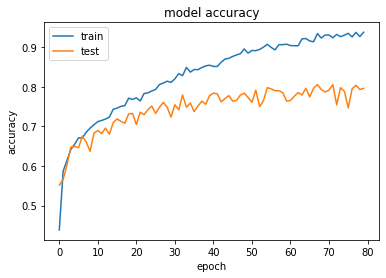

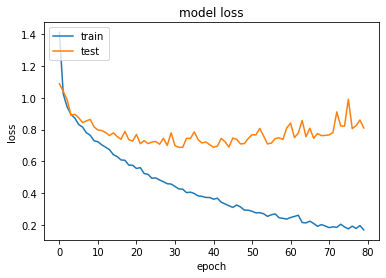

In [26]:
# list all data in history
print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


## **Defining a function to compare the actual and the predicted facies plots**

In [27]:
def compare_facies_plot(logs, test, pred, facies_colors):
    #make sure logs are sorted by depth

    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    
    cluster1 = np.repeat(test, 100, 1)
    cluster2 = np.repeat(pred, 100, 1)
    # print(cluster1.shape)

    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 48))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=10)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=10)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((90*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel('Prediction')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

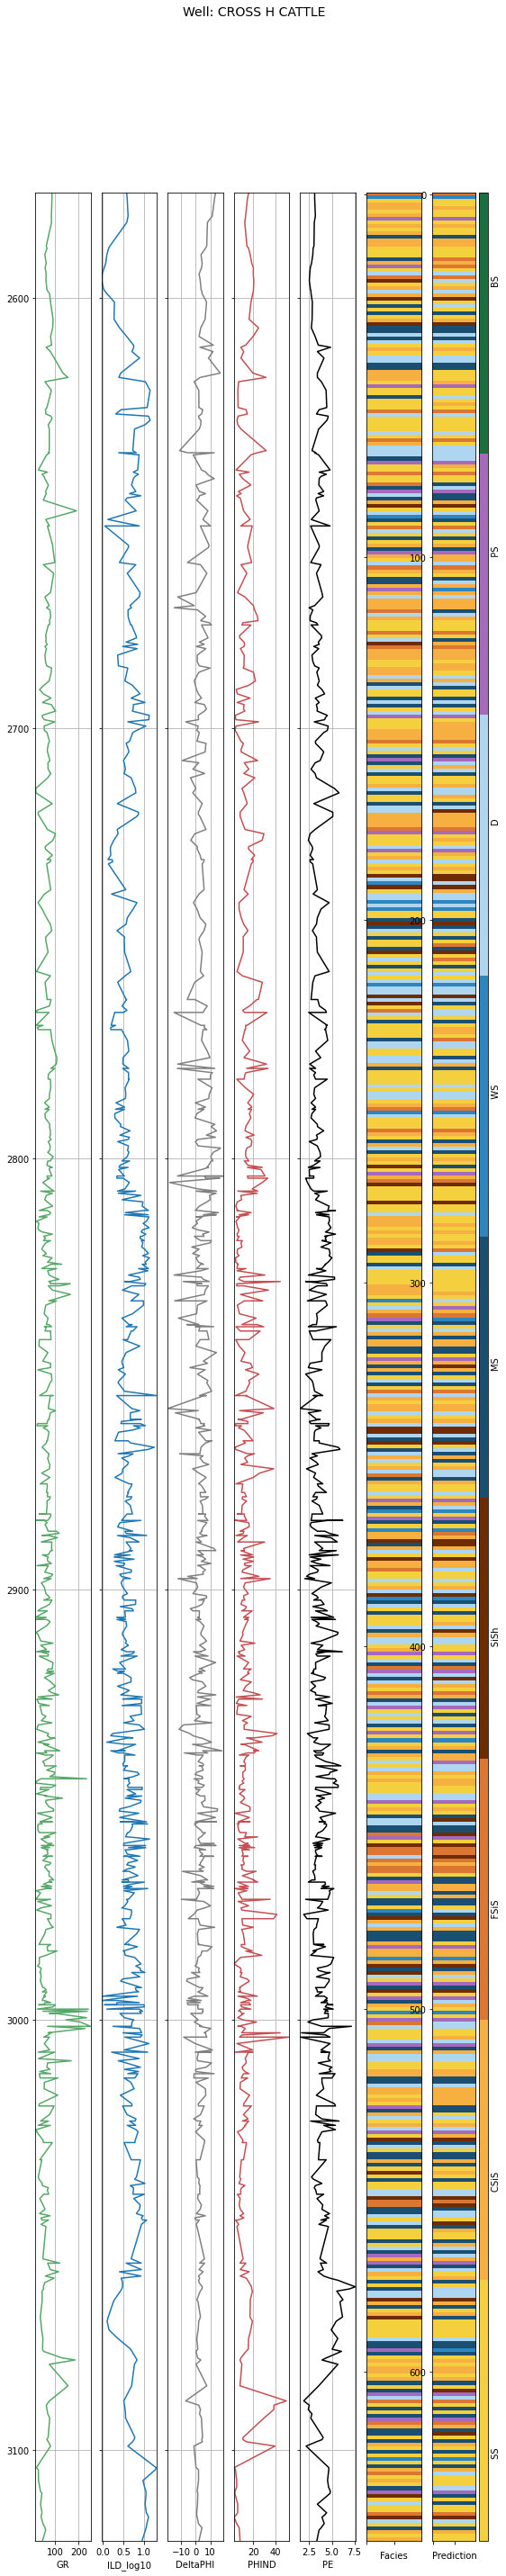

In [28]:
# print(X_test_data)
compare_facies_plot(X_test_data, y_t, y_pred, facies_colors)

## Applying the classification model to new data

Now that we have a trained facies classification model we can use it to identify facies in wells that do not have core data.  In this case, we will apply the classifier to two wells, but we could use it on any number of wells for which we have the same set of well logs for input.

This dataset is similar to the training data except it does not have facies labels.  It is loaded into a dataframe called `test_data`.

In [30]:
well_data = pd.read_csv('new_data_nofacies.csv')

# x = pd.get_dummies(well_data['Well Name']) # creating dummy variables
well_data_modified = well_data.drop('Well Name', axis=1)
# well_data_modified = well_data_modified.join(x, lsuffix='_left', rsuffix='_right') # appending dummy variables to the right of the dataset

well_data_modified.head()

,Formation,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,A1 SH,2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000
1,A1 SH,2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978
2,A1 SH,2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956
3,A1 SH,2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933
4,A1 SH,2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911


In [31]:
# get the features in X
X_new = well_data_modified.iloc[:,1:].values # dropped the Formation column

X_new.shape

(830, 8)

The data needs to be scaled using the same constants we used for the training data.

In [32]:
X_new = sc.transform(X_new)

Finally we predict facies labels for the unknown data, and store the results in a `Facies` column of the `test_data` dataframe.

In [33]:
#predict facies of unclassified data
y_new = model.predict(X_new)
y_new.shape

(830, 9)

In [34]:
# Inserting new coloumn
y_new = np.argmax(y_new, axis=1)
y_new = np.reshape(y_new,(830,1))
y_new = y_new + 1

# Displaying the predicted Facies
well_data['Facies'] = y_new
well_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,3
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,3
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,3
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,3
...,...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639,7
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611,7
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583,7
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556,7


We can use the well log plot to view the classification results along with the well logs.

(474, 100)
(356, 100)


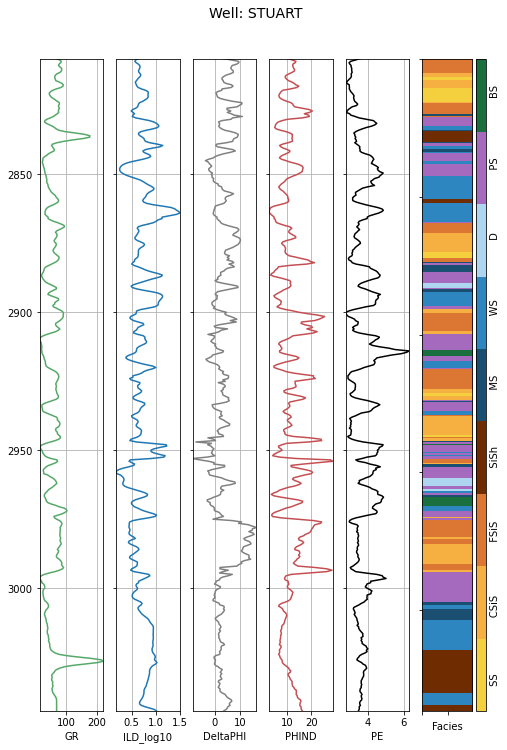

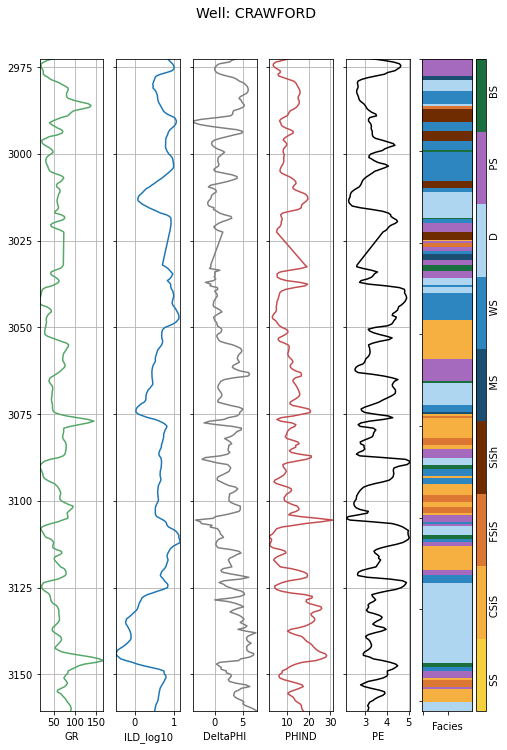

In [35]:
make_facies_log_plot(
    well_data[well_data['Well Name'] == 'STUART'],
    facies_colors=facies_colors)

make_facies_log_plot(
    well_data[well_data['Well Name'] == 'CRAWFORD'],
    facies_colors=facies_colors)

Finally we can write out a csv file with the well data along with the facies classification results.

In [36]:
well_data.to_csv('well_data_with_facies.csv')

In [39]:
well_data_with_facies = pd.read_csv('well_data_with_facies.csv')

well_data_with_facies.head()

,Unnamed: 0,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,0,A1 SH,STUART,2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000,3
1,1,A1 SH,STUART,2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978,3
2,2,A1 SH,STUART,2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956,3
3,3,A1 SH,STUART,2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933,3
4,4,A1 SH,STUART,2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911,3


## References

Amato del Monte, A., 2015. Seismic Petrophysics: Part 1, *The Leading Edge*, 34 (4). [doi:10.1190/tle34040440.1](http://dx.doi.org/10.1190/tle34040440.1)

Bohling, G. C., and M. K. Dubois, 2003. An Integrated Application of Neural Network and Markov Chain Techniques to Prediction of Lithofacies from Well Logs, *KGS Open-File Report* 2003-50, 6 pp. [pdf](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf)

Dubois, M. K., G. C. Bohling, and S. Chakrabarti, 2007, Comparison of four approaches to a rock facies classification problem, *Computers & Geosciences*, 33 (5), 599-617 pp. [doi:10.1016/j.cageo.2006.08.011](http://dx.doi.org/10.1016/j.cageo.2006.08.011)